In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 8
NUM_CLASSES = 5
EPOCHS_BASELINE = 5

In [ ]:
train_dir = "c:/Users/bachbach/Desktop/archive/train"
val_dir = "c:/Users/bachbach/Desktop/archive/val"

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"  
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  
    include_top=False,  
    input_shape=(299, 299, 3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax") 
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_BASELINE
)

Epoch 1/5
181/181 [==============================] - 73s 369ms/step - loss: 1.2878 - accuracy: 0.4586 - precision: 0.5731 - recall: 0.1826 - auc: 0.7696 - val_loss: 1.1919 - val_accuracy: 0.4867 - val_precision: 0.6195 - val_recall: 0.2228 - val_auc: 0.8101
Epoch 2/5
181/181 [==============================] - 59s 325ms/step - loss: 1.1897 - accuracy: 0.4929 - precision: 0.6073 - recall: 0.2484 - auc: 0.8055 - val_loss: 1.1721 - val_accuracy: 0.4794 - val_precision: 0.6073 - val_recall: 0.3015 - val_auc: 0.8122
Epoch 3/5
181/181 [==============================] - 61s 337ms/step - loss: 1.1510 - accuracy: 0.5116 - precision: 0.6162 - recall: 0.2837 - auc: 0.8195 - val_loss: 1.1572 - val_accuracy: 0.4915 - val_precision: 0.5954 - val_recall: 0.2494 - val_auc: 0.8159
Epoch 4/5
181/181 [==============================] - 62s 340ms/step - loss: 1.1306 - accuracy: 0.5246 - precision: 0.6345 - recall: 0.3065 - auc: 0.8269 - val_loss: 1.1448 - val_accuracy: 0.4988 - val_precision: 0.6201 - val_r

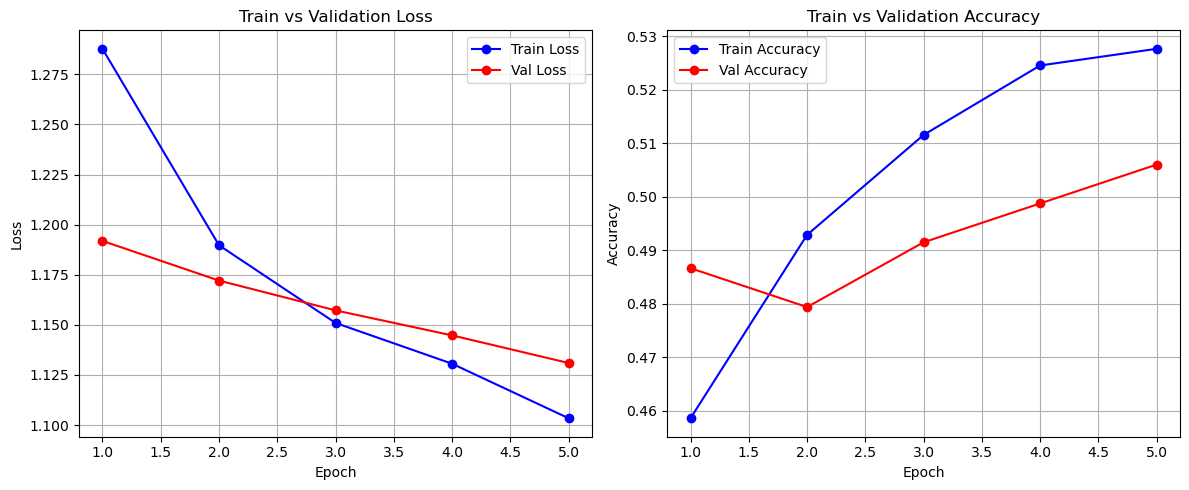

In [ ]:
epochs = range(1, EPOCHS_BASELINE + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [38]:
model.save("xception_baseline.h5")


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.models import load_model 

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon() 
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        cross_entropy = -y_true * K.log(y_pred)
    
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

In [ ]:
model = load_model("xception_baseline.h5", custom_objects={"focal_loss_fixed": focal_loss(gamma=2.0, alpha=0.25)})

for layer in model.layers[-20:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss=focal_loss(gamma=2.0, alpha=0.25),  
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
EPOCHS_FINE_TUNE = 5

fine_tune_history = model.fit(
    train_dataset,  
    validation_data=val_dataset,  
    epochs=EPOCHS_FINE_TUNE  
)

Epoch 1/5
723/723 [==============================] - 218s 294ms/step - loss: 0.1666 - accuracy: 0.4785 - precision: 0.6378 - recall: 0.1198 - auc: 0.7957 - val_loss: 0.2749 - val_accuracy: 0.2567 - val_precision: 0.5000 - val_recall: 0.0012 - val_auc: 0.5395
Epoch 2/5
723/723 [==============================] - 221s 305ms/step - loss: 0.1269 - accuracy: 0.5635 - precision: 0.6928 - recall: 0.2435 - auc: 0.8574 - val_loss: 0.1276 - val_accuracy: 0.5690 - val_precision: 0.7109 - val_recall: 0.2203 - val_auc: 0.8559
Epoch 3/5
723/723 [==============================] - 209s 289ms/step - loss: 0.1049 - accuracy: 0.6146 - precision: 0.7391 - recall: 0.3496 - auc: 0.8903 - val_loss: 0.1204 - val_accuracy: 0.6090 - val_precision: 0.6782 - val_recall: 0.3547 - val_auc: 0.8695
Epoch 4/5
723/723 [==============================] - 224s 309ms/step - loss: 0.0871 - accuracy: 0.6687 - precision: 0.7807 - recall: 0.4553 - auc: 0.9163 - val_loss: 0.1200 - val_accuracy: 0.6005 - val_precision: 0.6797 - v

In [73]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

EPOCHS_ADDITIONAL = 3

fine_tune_history_additional = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_ADDITIONAL  
)

Epoch 1/3
723/723 [==============================] - 205s 283ms/step - loss: 0.0644 - accuracy: 0.7323 - precision: 0.8262 - recall: 0.5668 - auc: 0.9450 - val_loss: 0.1346 - val_accuracy: 0.5811 - val_precision: 0.6691 - val_recall: 0.4479 - val_auc: 0.8679
Epoch 2/3
723/723 [==============================] - 185s 256ms/step - loss: 0.0552 - accuracy: 0.7593 - precision: 0.8453 - recall: 0.6135 - auc: 0.9564 - val_loss: 0.1346 - val_accuracy: 0.5944 - val_precision: 0.6758 - val_recall: 0.4492 - val_auc: 0.8699
Epoch 3/3
723/723 [==============================] - 210s 291ms/step - loss: 0.0463 - accuracy: 0.7864 - precision: 0.8576 - recall: 0.6565 - auc: 0.9654 - val_loss: 0.1421 - val_accuracy: 0.5726 - val_precision: 0.6551 - val_recall: 0.4576 - val_auc: 0.8665


In [74]:
test_dir = "c:/Users/bachbach/Desktop/archive/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  
    batch_size=32,
    class_mode='categorical', 
    shuffle=False  
)

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

Found 1656 images belonging to 5 classes.
52/52 [==============================] - 16s 315ms/step - loss: 0.1402 - accuracy: 0.5501 - precision: 0.6592 - recall: 0.4076 - auc: 0.8610
Test Loss: 0.1401681900024414
Test Accuracy: 0.5501207709312439
Test Precision: 0.6591796875
Test Recall: 0.40760868787765503
Test AUC: 0.8610344529151917
